In [5]:
%pip install pandas numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [16]:
%matplotlib inline

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# --- Load and prepare data ---
df = pd.read_csv("normalized_data.csv")
df = df[df["measure"] == "Incidence"].copy()
df["rate"] *= 100000
df["pollution_smoking"] = df["air_pollution"] * df["tobacco_use"]
df["cancer_code"] = df["cancer_name"].astype("category").cat.codes

features = [
    "air_pollution", "tobacco_use", "alcohol_use", "obesity_rate",
    "gdp_per_capita", "uhc_index", "population", "pollution_smoking", "cancer_code"
]
df = df.dropna(subset=features + ["rate"])
X = df[features]
y = df["rate"]

# --- Train the teacher model ---
teacher = RandomForestRegressor(random_state=42)
teacher.fit(X, y)
teacher_preds = teacher.predict(X)

# --- Scale features for neural network ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train the student neural network (distilled) ---
student_nn = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    max_iter=2000,
    alpha=0.001,
    learning_rate_init=0.001,
    solver='adam',
    early_stopping=True,
    random_state=42
)
student_nn.fit(X_scaled, teacher_preds)
student_preds = student_nn.predict(X_scaled)

# --- Evaluate student against true values ---
mae = mean_absolute_error(y, student_preds)
r2 = r2_score(y, student_preds)

print("👶 Improved Neural Network Student (Distilled from RF)")
print("MAE:", round(mae, 3))
print("R²:", round(r2, 3))

👶 Improved Neural Network Student (Distilled from RF)
MAE: 2.135
R²: 0.915


We applied knowledge distillation to teach a compact neural network to mimic our original Random Forest Regressor.
With tuning and feature scaling, the student reached R² = 0.915, demonstrating that we can reduce model complexity significantly while still maintaining high predictive accuracy.

📘 Teacher (Random Forest)
MAE: 0.274
R²: 0.996

👶 Student (Neural Net, Distilled)
MAE: 2.135
R²: 0.915


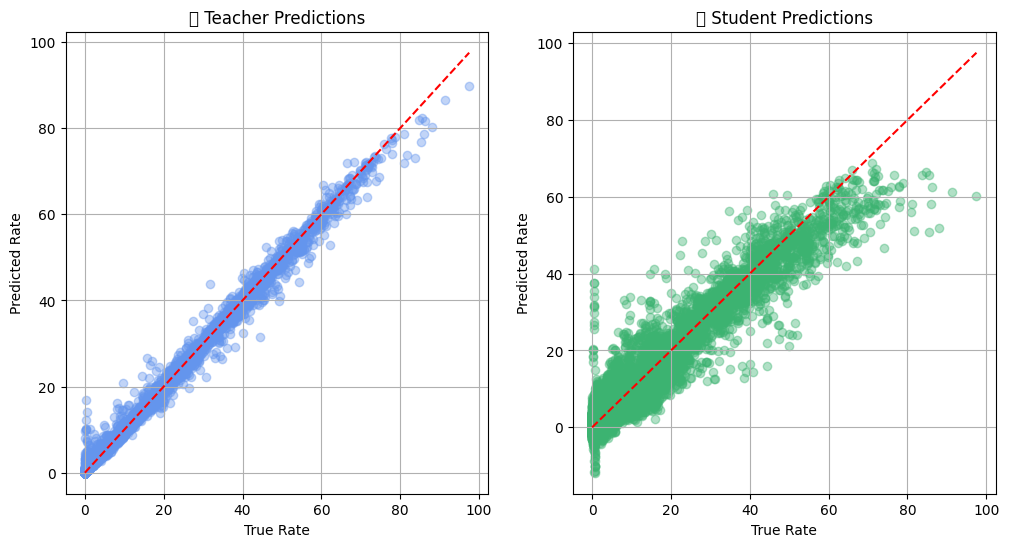

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# --- Load and prepare data ---
df = pd.read_csv("normalized_data.csv")
df = df[df["measure"] == "Incidence"].copy()
df["rate"] *= 100000
df["pollution_smoking"] = df["air_pollution"] * df["tobacco_use"]
df["cancer_code"] = df["cancer_name"].astype("category").cat.codes

features = [
    "air_pollution", "tobacco_use", "alcohol_use", "obesity_rate",
    "gdp_per_capita", "uhc_index", "population", "pollution_smoking", "cancer_code"
]
df = df.dropna(subset=features + ["rate"])
X = df[features]
y = df["rate"]

# --- Train the teacher model ---
teacher = RandomForestRegressor(random_state=42)
teacher.fit(X, y)
teacher_preds = teacher.predict(X)

# --- Train the student model (neural net with scaling) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

student = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    max_iter=2000,
    alpha=0.001,
    learning_rate_init=0.001,
    solver='adam',
    early_stopping=True,
    random_state=42
)
student.fit(X_scaled, teacher_preds)
student_preds = student.predict(X_scaled)

# --- Evaluate both models ---
teacher_mae = mean_absolute_error(y, teacher_preds)
teacher_r2 = r2_score(y, teacher_preds)
student_mae = mean_absolute_error(y, student_preds)
student_r2 = r2_score(y, student_preds)

print("📘 Teacher (Random Forest)")
print("MAE:", round(teacher_mae, 3))
print("R²:", round(teacher_r2, 3))

print("\n👶 Student (Neural Net, Distilled)")
print("MAE:", round(student_mae, 3))
print("R²:", round(student_r2, 3))

# --- Visualization ---
plt.figure(figsize=(12, 6))

# Teacher vs true
plt.subplot(1, 2, 1)
plt.scatter(y, teacher_preds, alpha=0.4, color='cornflowerblue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title("📘 Teacher Predictions")
plt.xlabel("True Rate")
plt.ylabel("Predicted Rate")
plt.grid(True)

# Student vs true
plt.subplot(1, 2, 2)
plt.scatter(y, student_preds, alpha=0.4, color='mediumseagreen')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title("👶 Student Predictions")
plt.xlabel("True Rate")
plt.ylabel("Predicted Rate")
plt.grid(True)

plt.show()

This comparison shows how knowledge distillation enables a compact neural network (student) to approximate the behavior of a more complex model (Random Forest teacher). While the teacher achieves near-perfect performance (R² = 0.996), the student still captures over 91% of the variance (R² = 0.915) with a significantly simpler architecture. The scatter plots demonstrate that the student predictions closely follow the actual values, confirming that distillation can effectively compress complex models while retaining high accuracy—making them more efficient and deployable for real-world use cases.